In [3]:
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
import logging

# Setup paths
PROJECT_ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Setup directories
MODEL_DIR = os.path.join(os.getcwd(), 'model')
RESULTS_DIR = os.path.join(os.getcwd(), 'results')
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Imports
from preprocessing.data_container import DataContainer
from preprocessing.block_data import create_block_data
from utils.evaluation import cindex_score
from models.modelling_process import ModellingProcess
from sksurv.ensemble import RandomSurvivalForest


# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [4]:
DATA_CONFIG = {
    'use_pca': False,
    'pca_threshold': 0.95,
    'gene_type': 'all_genes',
    'use_imputed': True,
    'use_cohorts': False, 
    'select_random' : False, 
    'requires_ohenc' : True, 
    # Auf True wenn NUR pDaten verwendet werden sollen
    'only_pData': False,
    # Nur benötigt wenn pDaten mitgefitten werden sollen
    'clinical_covs' : ["AGE", "TISSUE", "GLEASON_SCORE", 'PRE_OPERATIVE_PSA']
}

In [5]:
mp = ModellingProcess()
mp.prepare_data(DATA_CONFIG, PROJECT_ROOT) 

2025-01-15 11:07:35,451 - INFO - Loading data...
2025-01-15 11:08:09,951 - INFO - Found clinical data specification
2025-01-15 11:08:10,163 - INFO - Loaded data: 1091 samples, 56728 features


<class 'pandas.core.frame.DataFrame'>
Index: 1091 entries, Atlanta_2014_Long.PT081 to Stockholm_2016_Ross_Adams.STKHLM9246
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AGE                1091 non-null   float64
 1   TISSUE             1091 non-null   object 
 2   CLIN_T_STAGE       1091 non-null   object 
 3   PATH_T_STAGE       1091 non-null   object 
 4   GLEASON_SCORE      1091 non-null   float64
 5   PRE_OPERATIVE_PSA  1091 non-null   float64
 6   MONTH_TO_BCR       1091 non-null   float64
 7   BCR_STATUS         1091 non-null   int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 76.7+ KB
None


In [6]:
pData = mp.X.iloc[:, 0:6]
X = mp.X.iloc[:, 6:]
X['cohort'] = mp.groups

In [7]:
import pandas as pd

def create_block_data2(pData, X, threshold_cohorts = 2): 
    ov_coh_per_gene = list()
    if 'cohort' in X.columns: 
        X_tmp = X.drop(labels='cohort', axis = 1)
    else: 
        X_tmp = X
    for name, values in X_tmp.items():
        genes = X['cohort'][values.notna() == True].unique().tolist()
        #if len(genes) < 9:
        res = {'cohort' : '-'.join(genes), 'gene' : name, 'len' : len(genes)}
        ov_coh_per_gene.append(res)
        
    ov_coh_per_gene_df = pd.DataFrame(ov_coh_per_gene)
    
    block_data = [] 
    block_indcs = []
    # create block Dataframe
    nmb_pdata = len(pData.columns)
    print(nmb_pdata)
    block_data.append(pData)
    i_start = 0
    for index, cohs in enumerate(ov_coh_per_gene_df['cohort'].unique()):
        cohs_list = cohs.split('-')
        nmb_cohs = len(cohs_list)
        genes = ov_coh_per_gene_df['gene'][ov_coh_per_gene_df['cohort'] == cohs]
        nmb_genes = len(genes)
        if nmb_cohs >= 7 and nmb_genes > 100 or nmb_cohs > threshold_cohorts and nmb_genes > 300:
            sel_genes = X.loc[:, genes]
            block_data.append(sel_genes)
            indx_dict = {'nmb_cohs':nmb_cohs, 'nmb_genes': nmb_genes, 'i_start': i_start, 'i_end' : i_start + nmb_genes + nmb_pdata -1}
            i_start = i_start + nmb_genes + nmb_pdata 
            block_indcs.append(indx_dict)   
            nmb_pdata = 0 
    
    df_block_data = pd.concat(block_data, axis = 1)
    df_block_data['cohort'] = X['cohort']
    df_block_indices = pd.DataFrame(block_indcs).sort_values(by = ['nmb_cohs', 'nmb_genes'], ascending= False)
    return df_block_data, df_block_indices

In [8]:
df_block_data, df_block_indices = create_block_data2(pData=pData, X = X, threshold_cohorts=2)

6


In [9]:
df_block_indices

,nmb_cohs,nmb_genes,i_start,i_end
0,9,13214,0,13219
2,8,2240,14895,17134
1,8,1675,13220,14894
13,8,151,40406,40556
4,7,591,22438,23028
5,7,188,23029,23216
10,7,158,39300,39457
9,6,586,38714,39299
6,5,3320,23217,26536
11,5,494,39458,39951


In [10]:
df_block_data.reset_index(inplace=True)

In [11]:
df_block_data[df_block_data['cohort'] == 'Atlanta_2014_Long']

,index,TISSUE_FFPE,TISSUE_Fresh_frozen,TISSUE_Snap_frozen,AGE,GLEASON_SCORE,PRE_OPERATIVE_PSA,ENSG00000000003,ENSG00000000005,ENSG00000000419,...,ENSG00000283809,ENSG00000284159,ENSG00000284508,ENSG00000284736,ENSG00000286078,ENSG00000286101,ENSG00000286725,ENSG00000287321,ENSG00000288604,cohort
0,Atlanta_2014_Long.PT081,1.0,0,0,2.540970,-0.094820,-0.341467,-3.006631,-0.622789,1.705887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atlanta_2014_Long
1,Atlanta_2014_Long.PT127,1.0,0,0,-0.018317,-1.675161,-0.361595,0.044560,-0.622789,0.520111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atlanta_2014_Long
2,Atlanta_2014_Long.PT168,1.0,0,0,0.282775,-1.675161,-0.837332,0.975390,-0.622789,0.104950,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atlanta_2014_Long
3,Atlanta_2014_Long.PT184,1.0,0,0,-0.469956,-0.094820,-0.251809,0.744177,-0.622789,0.137887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atlanta_2014_Long
4,Atlanta_2014_Long.PT199,1.0,0,0,-0.620502,-0.094820,-0.542741,0.316196,-0.622789,0.595612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atlanta_2014_Long
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Atlanta_2014_Long.CM.4-0043,1.0,0,0,0.095933,-0.094820,-0.169470,0.512386,0.609789,1.135350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atlanta_2014_Long
96,Atlanta_2014_Long.CM.4-0044,1.0,0,0,-1.406643,-0.094820,-0.727547,0.573578,-0.622789,0.734819,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atlanta_2014_Long
97,Atlanta_2014_Long.CM.4-0046,1.0,0,0,-0.372617,-0.094820,1.678588,0.387468,-0.622789,0.463955,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atlanta_2014_Long
98,Atlanta_2014_Long.CM.4-0053,1.0,0,0,0.064586,1.485520,0.018996,0.574476,-0.622789,-0.075097,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atlanta_2014_Long


In [12]:
# from rpy2.robjects import pandas2ri, r

# pandas2ri.activate()
# r_df_block_data = pandas2ri.py2rpy(df_block_data)
# #r_df_block_indices = pandas2ri.py2rpy(df_block_data)

# r['saveRDS'](r_df_block_data, file="block_data.rds", compress=True)
# #r['saveRDS'](r_df_block_indices, file="block_indices.rds", compress=True)

df_block_indices.to_csv('df_block_indices_small.csv', index=False)
df_block_data.to_csv('df_block_data_small.csv', index=False)


In [7]:
# get groups of missing genes? 
# X['cohort'][X.iloc[:, 15494].notna() == True].unique().tolist()


# Per gene the cohorts in which it is present 
ov_coh_per_gene = list()
X_tmp = X.drop(labels='cohort', axis = 1)
for name, values in X_tmp.items():
    genes = X['cohort'][values.notna() == True].unique().tolist()
    #if len(genes) < 9:
    res = {'cohorts' : '-'.join(genes), 'gene' : name, 'len' : len(genes)}
    ov_coh_per_gene.append(res)
    
ov_coh_per_gene_df = pd.DataFrame(ov_coh_per_gene)
#ov_df_counts = ov_df.groupby(['cohorts', 'gene'])['gene'].count().reset_index(name="gene").sort_values('gene', ascending= False)
#ov_df_counts 

In [13]:
block_data = [] 
block_indcs = []
# create block Dataframe
i_start = 0
for index, cohs in enumerate(ov_coh_per_gene_df['cohorts'].unique()):
    cohs_list = cohs.split('-')
    nmb_cohs = len(cohs_list)
    genes = ov_coh_per_gene_df['gene'][ov_coh_per_gene_df['cohorts'] == cohs]
    nmb_genes = len(genes)
    if nmb_genes > 1:
        sel_genes = X.loc[:, genes]
        block_data.append(sel_genes)
        indx_dict = {'nmb_cohs':nmb_cohs, 'nmb_genes': nmb_genes, 'i_start': i_start, 'i_end' : i_start + nmb_genes -1}
        i_start = i_start + nmb_genes
        block_indcs.append(indx_dict)    

In [72]:
df_block_data = pd.concat(block_data, axis = 1)
df_block_indices = pd.DataFrame(block_indcs).sort_values(by = ['nmb_cohs', 'nmb_genes'], ascending= False)

NameError: name 'block_data' is not defined

In [15]:
df_block_data

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000271598,ENSG00000285304,ENSG00000273804,ENSG00000255726,ENSG00000260482,ENSG00000270955,ENSG00000233437,ENSG00000259813,ENSG00000285446,ENSG00000288646
Atlanta_2014_Long.PT081,-3.006631,-0.622789,1.705887,0.234710,0.906281,-0.372955,-0.883206,-3.477133,-3.289121,-3.993471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Atlanta_2014_Long.PT127,0.044560,-0.622789,0.520111,0.840715,0.440554,0.035672,-0.932726,0.353031,0.178056,0.307130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Atlanta_2014_Long.PT168,0.975390,-0.622789,0.104950,1.722182,-0.308974,-0.676291,-0.529297,0.471131,0.632298,0.411310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Atlanta_2014_Long.PT184,0.744177,-0.622789,0.137887,0.569978,0.234893,-0.974835,0.080468,0.867739,-0.433796,0.727024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Atlanta_2014_Long.PT199,0.316196,-0.622789,0.595612,0.282694,-0.553280,-0.819195,0.212234,0.694016,0.235932,0.633217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Stockholm_2016_Ross_Adams.STKHLM8462,1.054221,-0.221158,0.914313,1.166952,-0.987476,-0.614258,-0.199152,0.936988,-0.093688,-0.421008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stockholm_2016_Ross_Adams.STKHLM8659,-0.376987,-0.595446,-0.413672,0.974346,0.512080,-0.778478,0.691598,-1.282891,0.338737,0.452078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stockholm_2016_Ross_Adams.STKHLM9157,-0.096840,0.003729,-0.922901,-1.304991,0.077976,-1.057037,-1.738007,0.256888,0.718058,-0.361297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stockholm_2016_Ross_Adams.STKHLM9161,-0.084071,-0.351288,-0.234087,-0.616688,-0.300022,-1.405359,-1.521836,0.442135,2.133783,0.010330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
min(df_block_indices.nmb_genes)

2

In [18]:
df_block_data.to_csv('df_block_data.csv')
df_block_indices.to_csv('df_block_indices.csv')

In [5]:
ov_long = pd.melt(X, id_vars = ['cohort'], value_name='value')
ov_long['indicator'] = ov_long['value'].notna().astype(int)

In [30]:
ov_long

,cohort,variable,value,indicator
0,Atlanta_2014_Long,ENSG00000000003,-3.006631,1
1,Atlanta_2014_Long,ENSG00000000003,0.044560,1
2,Atlanta_2014_Long,ENSG00000000003,0.975390,1
3,Atlanta_2014_Long,ENSG00000000003,0.744177,1
4,Atlanta_2014_Long,ENSG00000000003,0.316196,1
...,...,...,...,...
61883697,Stockholm_2016_Ross_Adams,ENSG00000288646,NaN,0
61883698,Stockholm_2016_Ross_Adams,ENSG00000288646,NaN,0
61883699,Stockholm_2016_Ross_Adams,ENSG00000288646,NaN,0
61883700,Stockholm_2016_Ross_Adams,ENSG00000288646,NaN,0


In [29]:
ov_long_grouped = ov_long.groupby(['cohort','variable'])['indicator'].mean().reset_index()

In [ ]:
ov_long = ov_long_grouped.groupby(['variable'])['cohort'].count().reset_index()

,variable,cohort
0,ENSG00000000003,9
1,ENSG00000000005,9
2,ENSG00000000419,9
3,ENSG00000000457,9
4,ENSG00000000460,9
...,...,...
56717,ENSG00000288663,9
56718,ENSG00000288669,9
56719,ENSG00000288670,9
56720,ENSG00000288674,9


In [ ]:
df_heatmap = ov_long_grouped.pivot(index = "cohort", columns="variable", values="indicator")

<Axes: xlabel='variable', ylabel='cohort'>

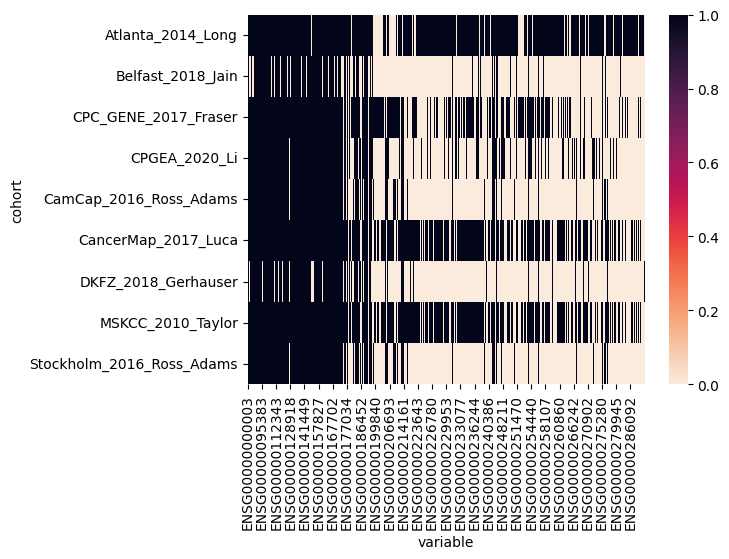

In [26]:
import seaborn as sns
sns.heatmap(df_heatmap, cmap = sns.cm.rocket_r)

,cohort,variable,value,indicator
0,Atlanta_2014_Long,ENSG00000000003,-3.006631,1
1,Atlanta_2014_Long,ENSG00000000003,0.044560,1
2,Atlanta_2014_Long,ENSG00000000003,0.975390,1
3,Atlanta_2014_Long,ENSG00000000003,0.744177,1
4,Atlanta_2014_Long,ENSG00000000003,0.316196,1
...,...,...,...,...
61883697,Stockholm_2016_Ross_Adams,ENSG00000288646,NaN,0
61883698,Stockholm_2016_Ross_Adams,ENSG00000288646,NaN,0
61883699,Stockholm_2016_Ross_Adams,ENSG00000288646,NaN,0
61883700,Stockholm_2016_Ross_Adams,ENSG00000288646,NaN,0


,genes,len,name
56,Atlanta_2014_Long-CancerMap_2017_Luca-MSKCC_20...,3,10715
0,Atlanta_2014_Long,1,5569
52,Atlanta_2014_Long-CancerMap_2017_Luca-CPC_GENE...,4,5303
50,Atlanta_2014_Long-CancerMap_2017_Luca-CPC_GENE...,5,3320
39,Atlanta_2014_Long-CamCap_2016_Ross_Adams-Cance...,8,2240
...,...,...,...
47,Atlanta_2014_Long-CamCap_2016_Ross_Adams-DKFZ_...,4,1
68,Belfast_2018_Jain-CamCap_2016_Ross_Adams-Cance...,6,1
69,Belfast_2018_Jain-CamCap_2016_Ross_Adams-Cance...,5,1
67,Belfast_2018_Jain-CamCap_2016_Ross_Adams-Cance...,7,1


In [ ]:
block_df = pd.DataFrame()

for index, row in ov_df_counts.iterrows(): 
    genes = ov_df[ov_df['genes'] == row['genes']]
    
    block_df.append()